In [2]:
!pip install scipy==1.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 28.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.2
    Uninstalling scipy-1.11.2:
      Successfully uninstalled scipy-1.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.9.0 which is incompatible.
fitter 1.6.0 requires pandas<3.0.0,>=2.0.3, but you have pandas 2.0.2 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.


In [3]:
!pip install scikit-image==0.19.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 70.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.21.0
    Uninstalling scikit-image-0.21.0:
      Successfully uninstalled scikit-image-0.21.0


# Importing Libraries

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from morpholayers.layers import Dilation2D, Erosion2D, Opening2D, Closing2D, Gradient2D
# from morpholayers.constraints import SEconstraint
# from morpholayers.initializers import SEinitializer,SparseZeros, RandomLattice
from sklearn.metrics import classification_report,confusion_matrix
import skimage
from skimage import color, exposure
from skimage import io
import cv2
import os
main_dir = "/kaggle/input/mango-leaf-bd-dataset"
# test_main_dir = "/kaggle/input/kaggle-curated-dataset1/kaggle_curated_dataset/"
#set the path to the train dir
train_dir = os.path.join(main_dir, 'Train')
# #set the path to the test dir
test_dir = os.path.join(main_dir, 'Test')
# #directory with the training covid images
# train_covid_dir = os.path.join(train_dir, '1')
# #directory with the training normal images
# train_normal_dir = os.path.join(train_dir, '0')
# # #directory with the testing covid images
# test_covid_dir = os.path.join(test_dir, '1')
# # #directory with the testing normal images
# test_normal_dir = os.path.join(test_dir, '0')

In [15]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 2


# Generate Training, Testing and Validation Batches for Xception Model

In [50]:
# generate training,testing and validation batches
img_width = 224
img_height = 224
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
dgen_train = ImageDataGenerator(
                                validation_split=0.2,
                                preprocessing_function = tf.keras.applications.xception.preprocess_input
                                )

dgen_validation = ImageDataGenerator(tf.keras.applications.xception.preprocess_input)
dgen_test = ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)

train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(img_width,img_height),
                                                 subset = 'training',
                                                 batch_size = BATCH_SIZE,
                                                 shuffle = True,
                                                 class_mode = 'categorical')

validation_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(img_width,img_height),
                                                 subset = 'validation',
                                                 batch_size = BATCH_SIZE,
                                                 shuffle = False,
                                                 class_mode = 'categorical')
test_generator = dgen_test.flow_from_directory(test_dir,
                                                 target_size=(img_width,img_height),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle = False)

Found 2642 images belonging to 8 classes.
Found 657 images belonging to 8 classes.
Found 379 images belonging to 8 classes.


# Generate Training, Testing and Validation Batches for RESNET50 Model

In [74]:
# generate training,testing and validation batches
img_width = 224
img_height = 224
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
dgen_train = ImageDataGenerator(
                                validation_split=0.2,
                                preprocessing_function = tf.keras.applications.resnet50.preprocess_input
                                )

dgen_validation = ImageDataGenerator(tf.keras.applications.resnet50.preprocess_input)
dgen_test = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet50.preprocess_input)

train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(img_width,img_height),
                                                 subset = 'training',
                                                 batch_size = BATCH_SIZE,
                                                 shuffle = True,
                                                 class_mode = 'categorical')

validation_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(img_width,img_height),
                                                 subset = 'validation',
                                                 batch_size = BATCH_SIZE,
                                                 shuffle = False,
                                                 class_mode = 'categorical')
test_generator = dgen_test.flow_from_directory(test_dir,
                                                 target_size=(img_width,img_height),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle = False)

Found 2642 images belonging to 8 classes.
Found 657 images belonging to 8 classes.
Found 379 images belonging to 8 classes.


In [51]:
import glob
train_image_names = glob.glob('/kaggle/input/mango-leaf-bd-dataset/Train/*/*.jpg')
print("Total number of training images: ", len(train_image_names))

# make train_image_names as serie object
train_image_names = pd.Series(train_image_names)

Total number of training images:  3299


In [53]:
# train_df: a dataframe with 2 field: Filename, ClassId
train_df = pd.DataFrame()

# generate Filename field
train_df['Filename'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])
# generate ClassId field
train_df['ClassId'] = train_image_names.map(lambda img_name: img_name.split("/")[-2])

train_df.head(10)

,Filename,ClassId
0,IMG_20211107_124627 (Custom).jpg,Powdery Mildew
1,IMG_20211107_125226 (Custom).jpg,Powdery Mildew
2,IMG_20211107_125656 (Custom).jpg,Powdery Mildew
3,20211109_121933 (Custom).jpg,Powdery Mildew
4,IMG_20211107_125339 (Custom).jpg,Powdery Mildew
5,IMG_20211107_115649 (Custom).jpg,Powdery Mildew
6,20211109_122151(0) (Custom).jpg,Powdery Mildew
7,IMG_20211107_130039 (Custom).jpg,Powdery Mildew
8,20211109_121859 (Custom).jpg,Powdery Mildew
9,20211109_121423 (Custom).jpg,Powdery Mildew


In [54]:
class_id_distribution = train_df['ClassId'].value_counts()
class_id_distribution.head(8)

ClassId
Sooty Mould         450
Healthy             450
Powdery Mildew      448
Die Back            437
Bacterial Canker    434
Gall Midge          432
Anthracnose         428
Cutting Weevil      220
Name: count, dtype: int64

# **Computing Class Weights**

In [55]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight= "balanced", classes = np.unique(class_id_distribution), y = class_id_distribution)

In [56]:
class_weights = dict(zip(np.unique(class_id_distribution), class_weights))
class_weights

{220: 1.1428571428571428,
 428: 1.1428571428571428,
 432: 1.1428571428571428,
 434: 1.1428571428571428,
 437: 1.1428571428571428,
 448: 1.1428571428571428,
 450: 0.5714285714285714}

In [58]:
train_generator.class_indices

{'Anthracnose': 0,
 'Bacterial Canker': 1,
 'Cutting Weevil': 2,
 'Die Back': 3,
 'Gall Midge': 4,
 'Healthy': 5,
 'Powdery Mildew': 6,
 'Sooty Mould': 7}

# **Xception Model Training and Testing**

In [59]:
from tensorflow.keras.applications.xception import Xception
#compile the model
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/kaggle/working/mango_leaf_classification_model_weights_omdena_xception.hdf5', save_best_only=True, save_weights_only=True)

callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)
_

with strategy.scope():
    model = Sequential()
    model.add(Xception(include_top=False, pooling='max', weights= 'imagenet'))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8))
    model.layers[0].trainable = False
    model.compile(Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

83683744/83683744 [==============================] - 3s 0us/step


In [60]:
#train the model
history = model.fit(train_generator,
                    epochs=50,
                    workers=8,
                    validation_data = validation_generator, callbacks = [checkpoint, callback])

Epoch 1/50
42/42 [==============================] - 30s 472ms/step - loss: 0.8247 - accuracy: 0.7400 - val_loss: 0.3467 - val_accuracy: 0.8813
Epoch 2/50
42/42 [==============================] - 18s 406ms/step - loss: 0.2450 - accuracy: 0.9190 - val_loss: 0.2823 - val_accuracy: 0.9041
Epoch 3/50
42/42 [==============================] - 16s 363ms/step - loss: 0.1663 - accuracy: 0.9428 - val_loss: 0.2349 - val_accuracy: 0.9269
Epoch 4/50
42/42 [==============================] - 16s 367ms/step - loss: 0.1337 - accuracy: 0.9531 - val_loss: 0.2019 - val_accuracy: 0.9315
Epoch 5/50
42/42 [==============================] - 15s 348ms/step - loss: 0.1234 - accuracy: 0.9591 - val_loss: 0.2323 - val_accuracy: 0.9254
Epoch 6/50
42/42 [==============================] - 15s 350ms/step - loss: 0.1008 - accuracy: 0.9656 - val_loss: 0.2208 - val_accuracy: 0.9254
Epoch 7/50
42/42 [==============================] - 16s 382ms/step - loss: 0.0837 - accuracy: 0.9739 - val_loss: 0.1971 - val_accuracy: 0.9330

Text(0.5, 0, 'epoch')

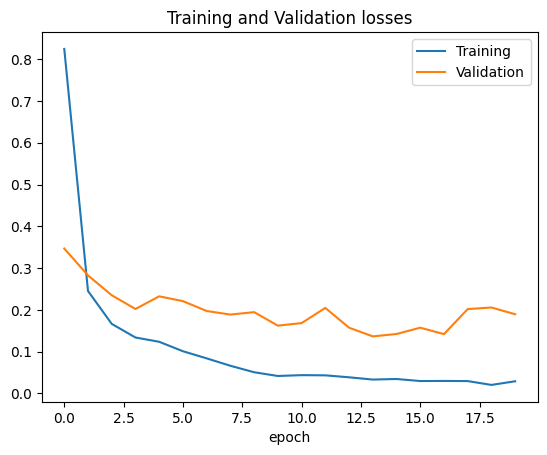

In [61]:
#plot graph between training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

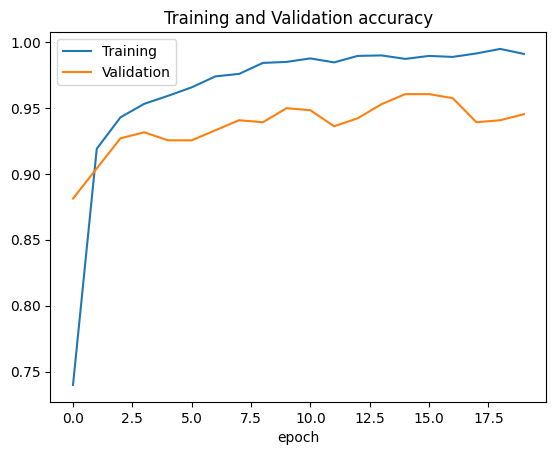

In [62]:
#plot graph between training and validation accuarcy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')

In [67]:
# get the test accuarcy and loss
test_loss , test_acc = model.evaluate(test_generator)

print('test loss :{} test acc :{}'.format(test_loss, test_acc))

12/12 [==============================] - 2s 107ms/step - loss: 0.0703 - accuracy: 0.9657
test loss :0.07034152746200562 test acc :0.9656991958618164


In [71]:
from keras.models import load_model
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the model
#model = load_model('/kaggle/working/covid_classification.h5')

# Make predictions on the test data
y_pred = model.predict(test_generator)

12/12 [==============================] - 2s 112ms/step


<Axes: >

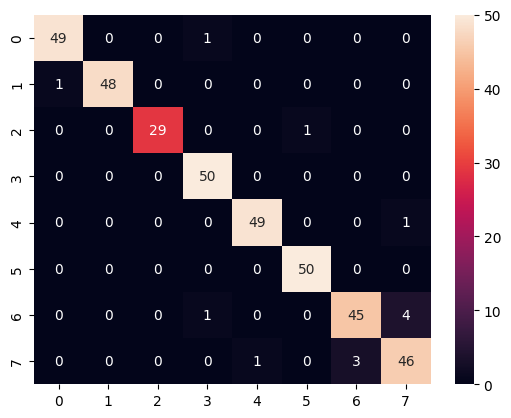

In [72]:
# Convert the predictions to binary labels
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels of the test data
y_true = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap to display the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')

In [73]:
cr = classification_report(y_true, y_pred, target_names=test_generator.class_indices)
print(cr)

                  precision    recall  f1-score   support

     Anthracnose       0.98      0.98      0.98        50
Bacterial Canker       1.00      0.98      0.99        49
  Cutting Weevil       1.00      0.97      0.98        30
        Die Back       0.96      1.00      0.98        50
      Gall Midge       0.98      0.98      0.98        50
         Healthy       0.98      1.00      0.99        50
  Powdery Mildew       0.94      0.90      0.92        50
     Sooty Mould       0.90      0.92      0.91        50

        accuracy                           0.97       379
       macro avg       0.97      0.97      0.97       379
    weighted avg       0.97      0.97      0.97       379



# **RESNET50 Model Training and Testing**

In [41]:
from tensorflow.keras.applications.resnet50 import ResNet50
#compile the model
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/kaggle/working/mango_leaf_classification_model_weights_omdena_resnet50.hdf5', save_best_only=True, save_weights_only=True)

callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)
_

with strategy.scope():
    model = Sequential()
    model.add(ResNet50(include_top=False, pooling='max', weights= 'imagenet'))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8))
    model.layers[0].trainable = False
    model.compile(Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [42]:
#train the model resnet
history = model.fit(train_generator,
                    epochs=50,
                    workers=8,
                    validation_data = validation_generator, callbacks = [checkpoint, callback])

Epoch 1/50
42/42 [==============================] - 28s 442ms/step - loss: 2.0265 - accuracy: 0.6968 - val_loss: 0.1641 - val_accuracy: 0.9452
Epoch 2/50
42/42 [==============================] - 15s 361ms/step - loss: 0.2907 - accuracy: 0.8936 - val_loss: 0.1116 - val_accuracy: 0.9619
Epoch 3/50
42/42 [==============================] - 15s 323ms/step - loss: 0.1962 - accuracy: 0.9307 - val_loss: 0.1621 - val_accuracy: 0.9406
Epoch 4/50
42/42 [==============================] - 15s 346ms/step - loss: 0.1209 - accuracy: 0.9557 - val_loss: 0.0769 - val_accuracy: 0.9772
Epoch 5/50
42/42 [==============================] - 15s 326ms/step - loss: 0.1095 - accuracy: 0.9621 - val_loss: 0.0647 - val_accuracy: 0.9772
Epoch 6/50
42/42 [==============================] - 15s 348ms/step - loss: 0.0929 - accuracy: 0.9640 - val_loss: 0.0472 - val_accuracy: 0.9802
Epoch 7/50
42/42 [==============================] - 14s 317ms/step - loss: 0.0763 - accuracy: 0.9716 - val_loss: 0.0728 - val_accuracy: 0.9726

Text(0.5, 0, 'epoch')

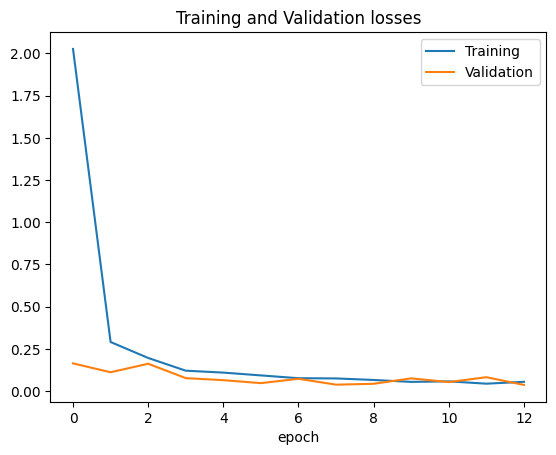

In [43]:
#plot graph between training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

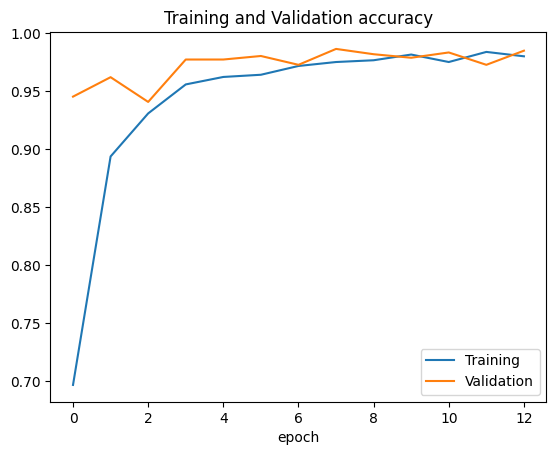

In [44]:
#plot graph between training and validation accuarcy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')

In [45]:
# get the test accuarcy and loss
test_loss , test_acc = model.evaluate(test_generator)

print('test loss :{} test acc :{}'.format(test_loss, test_acc))

12/12 [==============================] - 2s 108ms/step - loss: 0.0424 - accuracy: 0.9921
test loss :0.042365435510873795 test acc :0.9920844435691833


In [46]:
from keras.models import load_model
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the model
#model = load_model('/kaggle/working/covid_classification.h5')

# Make predictions on the test data
y_pred = model.predict(test_generator)

12/12 [==============================] - 5s 136ms/step


<Axes: >

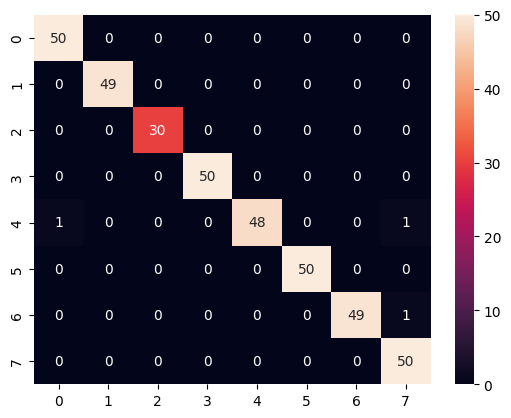

In [47]:
# Convert the predictions to binary labels
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels of the test data
y_true = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap to display the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')

In [48]:
cr = classification_report(y_true, y_pred, target_names=test_generator.class_indices)
print(cr)

                  precision    recall  f1-score   support

     Anthracnose       0.98      1.00      0.99        50
Bacterial Canker       1.00      1.00      1.00        49
  Cutting Weevil       1.00      1.00      1.00        30
        Die Back       1.00      1.00      1.00        50
      Gall Midge       1.00      0.96      0.98        50
         Healthy       1.00      1.00      1.00        50
  Powdery Mildew       1.00      0.98      0.99        50
     Sooty Mould       0.96      1.00      0.98        50

        accuracy                           0.99       379
       macro avg       0.99      0.99      0.99       379
    weighted avg       0.99      0.99      0.99       379

